In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere
from tqdm.notebook import tqdm

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Loc2Alt_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(1000, 176, 384)
(1000, 2)


If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [3]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [4]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [5]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:01<05:38,  1.13s/it]

Training Loss: 524202.60966712236 Validation Loss: 92621.71905994415


  4%|▎         | 11/300 [00:11<05:13,  1.08s/it]

Training Loss: 28111.978292137384 Validation Loss: 11924.740930497646


  7%|▋         | 21/300 [00:22<05:02,  1.08s/it]

Training Loss: 18020.322308063507 Validation Loss: 4878.562880381942


 10%|█         | 31/300 [00:33<04:50,  1.08s/it]

Training Loss: 15110.260559976101 Validation Loss: 4185.529410362244


 14%|█▎        | 41/300 [00:44<04:39,  1.08s/it]

Training Loss: 13083.892580538988 Validation Loss: 3897.7436463832855


 17%|█▋        | 51/300 [00:55<04:29,  1.08s/it]

Training Loss: 10949.854008805007 Validation Loss: 4449.313879370689


 20%|██        | 61/300 [01:05<04:12,  1.06s/it]

Training Loss: 9298.974350363016 Validation Loss: 5349.345174178481


 24%|██▎       | 71/300 [01:16<03:58,  1.04s/it]

Training Loss: 8583.944654636085 Validation Loss: 6600.119883865118


 27%|██▋       | 81/300 [01:26<03:40,  1.01s/it]

Training Loss: 6789.159384340048 Validation Loss: 5185.314402408898


 30%|███       | 91/300 [01:36<03:35,  1.03s/it]

Training Loss: 6215.445527330041 Validation Loss: 5332.325499482453


 34%|███▎      | 101/300 [01:46<03:21,  1.01s/it]

Training Loss: 5631.921468526125 Validation Loss: 4220.150767020881


 37%|███▋      | 111/300 [01:56<03:11,  1.01s/it]

Training Loss: 5288.116800434887 Validation Loss: 4426.97621512413


 40%|████      | 121/300 [02:06<03:00,  1.01s/it]

Training Loss: 4501.264354087412 Validation Loss: 4020.2033499479294


 44%|████▎     | 131/300 [02:16<02:51,  1.01s/it]

Training Loss: 4274.095016174018 Validation Loss: 4892.968916743994


 47%|████▋     | 141/300 [02:27<02:39,  1.00s/it]

Training Loss: 3874.9915029481053 Validation Loss: 3984.5054990053177


 50%|█████     | 151/300 [02:36<02:29,  1.01s/it]

Training Loss: 3647.5017491579056 Validation Loss: 3264.009425409138


 54%|█████▎    | 161/300 [02:47<02:19,  1.00s/it]

Training Loss: 3344.6045668423176 Validation Loss: 2598.8966105878353


 57%|█████▋    | 171/300 [02:57<02:10,  1.01s/it]

Training Loss: 3079.3165163099766 Validation Loss: 1908.9364753216505


 60%|██████    | 181/300 [03:07<02:00,  1.01s/it]

Training Loss: 2941.5424041394144 Validation Loss: 1475.6170240193605


 64%|██████▎   | 191/300 [03:17<01:48,  1.01it/s]

Training Loss: 2775.9667738713324 Validation Loss: 1218.999988719821


 67%|██████▋   | 201/300 [03:27<01:44,  1.06s/it]

Training Loss: 2572.7910871617496 Validation Loss: 1196.0381151735783


 70%|███████   | 211/300 [03:38<01:32,  1.04s/it]

Training Loss: 2423.9570702388883 Validation Loss: 1102.0570172965527


 74%|███████▎  | 221/300 [03:48<01:19,  1.01s/it]

Training Loss: 2331.465353243053 Validation Loss: 1008.2942032441497


 77%|███████▋  | 231/300 [03:58<01:09,  1.01s/it]

Training Loss: 2225.834879092872 Validation Loss: 988.9240789711475


 80%|████████  | 241/300 [04:08<01:00,  1.02s/it]

Training Loss: 2175.591168936342 Validation Loss: 988.780688278377


 84%|████████▎ | 251/300 [04:18<00:49,  1.02s/it]

Training Loss: 2134.31102476269 Validation Loss: 991.2787332050502


 87%|████████▋ | 261/300 [04:28<00:39,  1.02s/it]

Training Loss: 2100.061993330717 Validation Loss: 991.0280250161886


 90%|█████████ | 271/300 [04:39<00:29,  1.02s/it]

Training Loss: 2065.714643292129 Validation Loss: 955.8734305948019


 94%|█████████▎| 281/300 [04:49<00:19,  1.00s/it]

Training Loss: 2042.0867447573692 Validation Loss: 902.6878566518426


 97%|█████████▋| 291/300 [04:59<00:09,  1.00s/it]

Training Loss: 2008.1939079165459 Validation Loss: 844.51854435727


100%|██████████| 300/300 [05:08<00:00,  1.03s/it]


In [9]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: 0.48586051602954833
(128, 2)
(128, 2)


<IPython.core.display.Javascript object>


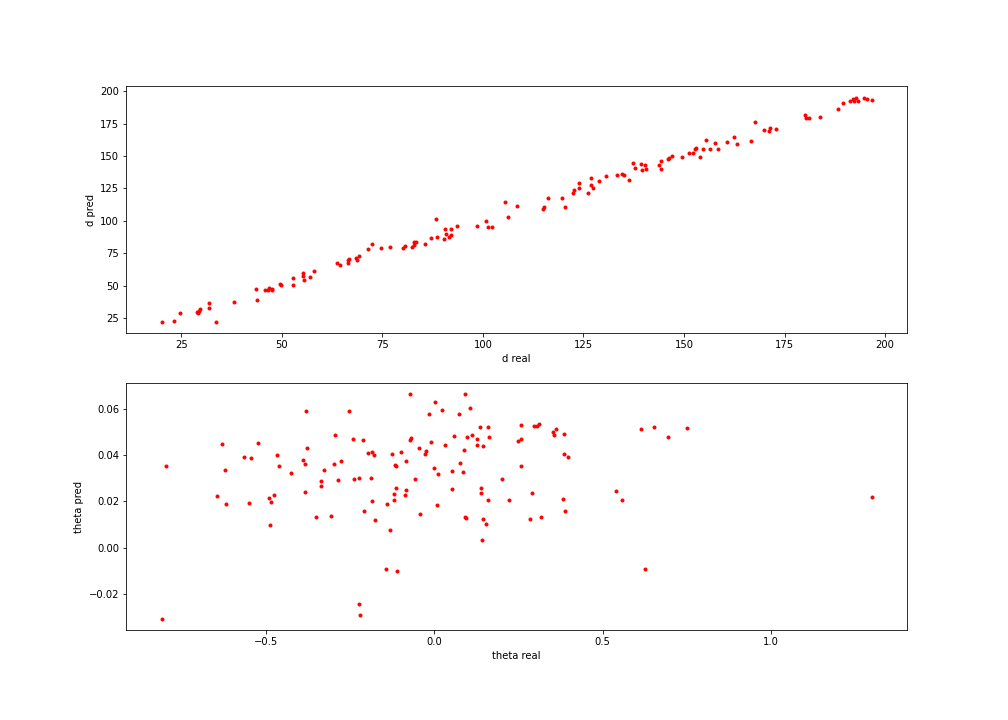

In [10]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))
#inf_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu', 'l_d']

# ax_h = plt.subplot(121)
# ax_h.scatter(h_lab, h_out, c='red', marker='.')
# ax_h.set_xlabel('h real')
# ax_h.set_ylabel('h pred')

# ax_p = plt.subplot(122)
# ax_p.scatter(phi_lab, phi_out, c='red', marker='.')
# ax_p.set_xlabel('phi real')
# ax_p.set_ylabel('phi pred')

ax_d = plt.subplot(211)
ax_d.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(212)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

# ax_t = plt.subplot(326)
# ax_t.scatter(y[:,5], output[:,5], c='red', marker='.')
# ax_t.set_xlabel('dendrite length real')
# ax_t.set_ylabel('dendrite length pred')

plt.show()

<IPython.core.display.Javascript object>


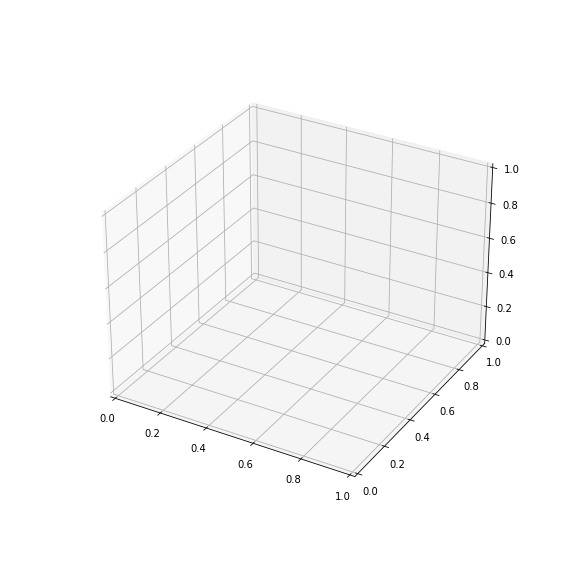

IndexError: index 2 is out of bounds for axis 1 with size 2

In [8]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()